# Projected Gradient Descent | EPOCH Lab: Ricoh

In [1]:
%pylab inline

from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms

Populating the interactive namespace from numpy and matplotlib


In [2]:
print("CUDA Available: ", torch.cuda.is_available())
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

CUDA Available:  False


In [3]:
model = models.inception_v3(pretrained=True).to(device)
model.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [4]:
!curl https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt --output data/imagenet_classes.txt
    
with open("data/imagenet_classes.txt", "r") as f:
    classes = [s.strip() for s in f.readlines()]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10472  100 10472    0     0  50700      0 --:--:-- --:--:-- --:--:-- 51586


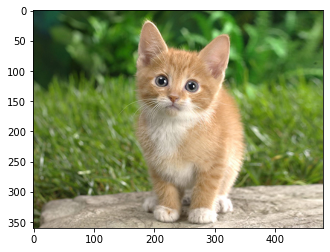

In [5]:
img = Image.open("/Volumes/artemis/library/datasets/cat.jpg")
plt.imshow(img)

In [6]:
preprocess = transforms.Compose([transforms.Resize(256),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                ])

In [7]:
input_tensor = preprocess(img).unsqueeze(0)

In [8]:
def predict(img):
    output = model(img)
    pred = F.softmax(output, dim=1)
    _, indicies = torch.topk(pred, k=1)
    for i in indicies.data.numpy().ravel():
        cost = pred.data[0][i]
        print("Class ID: {} | Label: {} | Accuracy: {}%".format(str(i), classes[i], 100 * cost))

In [9]:
predict(input_tensor)

Class ID: 282 | Label: tiger cat | Accuracy: 93.17092895507812%


### False Memory

In [10]:
min_bound = input_tensor - 0.1
max_bound = input_tensor + 0.1

In [11]:
def pdg_attack(image, origin, gradient, eps=0.3, alpha=2/255):
    image.requires_grad = False
    
    perturb_image = image + gradient.sign() * alpha
    eta = torch.clamp(perturb_image - origin, min=-eps, max=eps)
    
    image = torch.clamp(image + eta, min_bound, max_bound)
    return image

In [12]:
image = input_tensor.clone()
target = torch.tensor(282).unsqueeze(0)

In [13]:
image, target = image.to(device), target.to(device)

epochs = 10
for e in range(epochs):
    image.requires_grad = True
    
    origin = image.data
    
    output = model(image)
    loss = nn.CrossEntropyLoss()(output, target).to(device)

    model.zero_grad()
    loss.backward()
    
    gradient = image.grad.data

    image = pdg_attack(image, origin, gradient)
    
    predict(image)

Class ID: 285 | Label: Egyptian cat | Accuracy: 72.63957214355469%
Class ID: 285 | Label: Egyptian cat | Accuracy: 77.8708267211914%
Class ID: 151 | Label: Chihuahua | Accuracy: 83.46184539794922%
Class ID: 151 | Label: Chihuahua | Accuracy: 99.46048736572266%
Class ID: 151 | Label: Chihuahua | Accuracy: 99.96922302246094%
Class ID: 151 | Label: Chihuahua | Accuracy: 99.99165344238281%
Class ID: 151 | Label: Chihuahua | Accuracy: 99.99834442138672%
Class ID: 151 | Label: Chihuahua | Accuracy: 99.99961853027344%
Class ID: 151 | Label: Chihuahua | Accuracy: 99.99991607666016%
Class ID: 151 | Label: Chihuahua | Accuracy: 99.9999771118164%


In [14]:
denorm = transforms.Compose([transforms.Normalize(mean=[0, 0, 0], std=[1/0.229, 1/0.224, 1/0.225]),
                             transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1])])

In [15]:
def postprocess(data):
    image = denorm(data.squeeze()).detach().numpy()
    image = np.rollaxis(image, 0, 3)
    return image

In [16]:
attack_image = postprocess(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


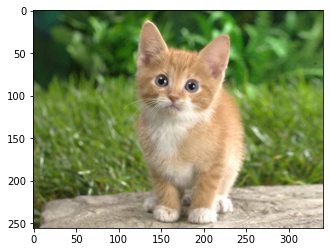

In [17]:
plt.imshow(attack_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


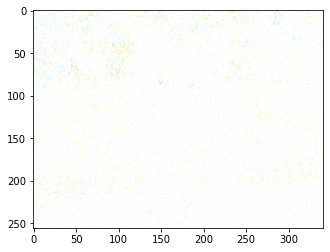

In [18]:
diff = (attack_image / postprocess(input_tensor))
plt.imshow(diff)